In [7]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Canny边缘检测算法是一种被广泛使用的边缘检测技术，由John F. Canny在1986年提出。它旨在从图像中提取有用的结构信息，并尽可能准确地标记边缘的位置。Canny算法的目标是满足三个主要标准：低错误率（边缘被正确检测），边缘定位的高精度（检测到的边缘尽可能接近真实边缘），以及对单个边缘的响应最小化（图像中的边缘只被标记一次）。为了达到这些目标，Canny边缘检测算法包括以下几个步骤：

### 1. 噪声降低

由于边缘检测容易受到图像噪声的影响，第一步是使用高斯滤波器平滑图像，以减少图像中的噪声。高斯滤波器是一种低通滤波器，可以移除图像中的高频部分（即噪声），同时保留低频部分（即边缘等重要结构）。


$$
G(x, y) = \frac{1}{2\pi\sigma^2} e^{-\frac{x^2 + y^2}{2\sigma^2}}
$$


### 2. 寻找图像梯度的强度和方向

接下来

，使用Sobel算法计算水平和垂直方向上的梯度强度。这一步骤可以揭示图像中亮度变化最显著的区域，即潜在的边缘位置。通过这两个方向的梯度，可以进一步计算出每个像素位置的边缘梯度强度（G）和方向（θ）：

- 梯度强度 $$ G = \sqrt{G_x^2 + G_y^2}$$
- 梯度方向 $$\theta = \arctan\left(\frac{G_y}{G_x}\right)$$



梯度方向被量化到四个主要方向之一（通常是0°, 45°, 90°, 和135°），这样做是为了简化后续的边缘跟踪过程。

### 3. 非极大值抑制

在这一步，算法会沿着梯度方向检查像素，仅保留梯度强度在该方向上局部最大的像素点，而非局部最大的点被认为不是边缘的一部分而被抑制。这一步骤的目的是去除那些模糊和宽敞的边缘，使边缘更加细薄。

### 4. 双阈值算法

为了进一步确定真正的边缘，Canny算法使用了双阈值方法来区分强边缘、弱边缘和非边缘。具体来说，设置两个阈值：高阈值和低阈值。高于高阈值的梯度被认为是强边缘；低于低阈值的梯度被认为是非边缘；而介于两者之间的梯度则被认为是弱边缘。

### 5. 边缘跟踪通过滞后

在最后一步，算法通过滞后技术处理弱边缘。只有当弱边缘与强边缘相连时，这些弱边缘才会被保留；否则，它们会被抑制。这样做可以确保只有真正的边缘被检测到，同时减少了错误检测的可能性。

Canny边缘检测算法因其准确性和鲁棒性而被广泛应用于各种图像处理场景中，尤其是在需要高精度边缘检测的应用中。

# 高斯濾波 
## 1. 使用OPENCV 
## 2. 手寫



$$
G(x, y) = \frac{1}{2\pi\sigma^2} e^{-\frac{x^2 + y^2}{2\sigma^2}}
$$

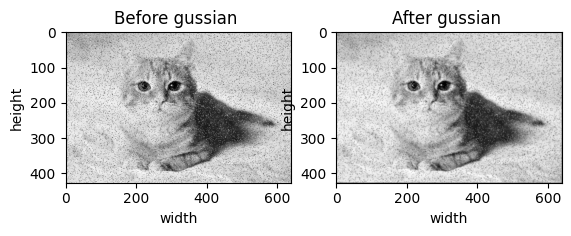

In [8]:
def show_img(img,title,xlabel,ylabel):
    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
def add_salt_and_pepper(img,fraction_salt:float,fraction_pepper:float):
    '''
    img:輸入的灰階圖像
    fraction_salt:整體影像的鹽比例255
    fraction_pepper:整體影像的胡椒比例
    return: 新的圖像
    '''
    row , col = img.shape[0:2]
    num_salt = int(np.ceil(fraction_salt * img.size ))#無條件進位並轉成整數
    num_pepper = int(np.ceil(fraction_pepper * img.size ))
    rand_arr = np.random.rand(img.shape[0],img.shape[1])
    # 複製原本圖片 
    output = img.copy()
    # randarr < fraction_salt 產生一個二維陣列 只要符合這個條件的都是true 
    # randarr > (1-fraction_pepper) 產生一個二維陣列 只要符合這個條件的都是true 
    output[rand_arr < fraction_salt] = 255
    output[rand_arr > (1-fraction_pepper)] = 0
    return output        

def get_guass_kernel(kernel_size, sigma):
    r = int(kernel_size//2)
    kernel = np.zeros((kernel_size, kernel_size))
    for y in range(0-r,0+r+1):
        for x in range(0-r,0+r+1):
            kernel[y+1,x+1] = 1/(2*np.pi*(sigma**2))*np.exp(-(x**2+y**2)/(2*(sigma**2)))
    # normalize 
    sum_of_kernel = np.sum(kernel)
    kernel = kernel / sum_of_kernel
    return kernel
def filter(img,kernel,kernel_size):
    r = kernel_size //2 # 圖片半徑 r=2 
    # print(img)
    height,width = img.shape[0:2]
    # 填充 
    padding_img = np.pad(img,(r,r)) 
    # print(padding_img)
    new_img = np.zeros_like(img)
    for y in range(r,height+r):
        for x in range(r,width+r):
            region = padding_img[(y-r):(y+r+1),(x-r):(x+r+1)]# y ,x = 2-2,2+2+1
            conv = np.sum(region*kernel)
            new_img[y-r,x-r] = conv
    return new_img
# get_guass_kernel(kernel_size=5,sigma=1.4)
img = cv2.imread("cat.jpeg")
gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
noise_img = add_salt_and_pepper(gray_img,0.05,0.05)
guass_kernel = get_guass_kernel(kernel_size=3,sigma=1)
gussian_img = filter(noise_img,guass_kernel,3)
plt.figure()
plt.subplot(1,2,1)
show_img(noise_img,"Before gussian ","width","height")
plt.subplot(1,2,2)
show_img(gussian_img,"After gussian ","width","height")# 

## 邊緣檢測 openCV

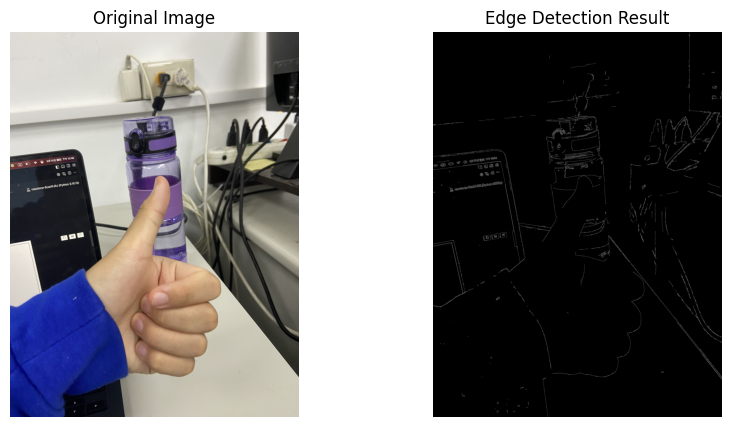

In [13]:
import cv2
import matplotlib.pyplot as plt

def show_img_with_matplotlib(color_img, title, pos):
    """將圖像用matplotlib顯示出來"""
    img_RGB = color_img[:, :, ::-1]
    ax = plt.subplot(1, 2, pos)
    plt.imshow(img_RGB)
    plt.title(title)
    plt.axis('off')

def canny_edge_detection(image_path):
    # 讀取原始圖像
    img = cv2.imread(image_path)
    
    # 轉換為灰度圖像，Canny邊緣檢測需要灰度圖
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 應用Canny邊緣檢測
    # 第一和第二個參數分別是低閾值和高閾值
    # 第三個參數設定梯度大小的孔徑，默認為3
    edges = cv2.Canny(gray_img, 50, 150, apertureSize=3)
    
    plt.figure(figsize=(10, 5))
    show_img_with_matplotlib(img, "Original Image", 1)
    show_img_with_matplotlib(cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR), "Edge Detection Result", 2)
    plt.show()

image_path = 'hw1/test1.jpeg'
canny_edge_detection(image_path)

## 邊緣檢測 手刻法

### 1. SOBEL GX GY G theta 計算 

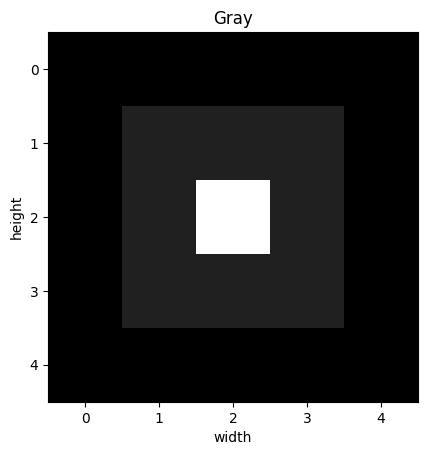

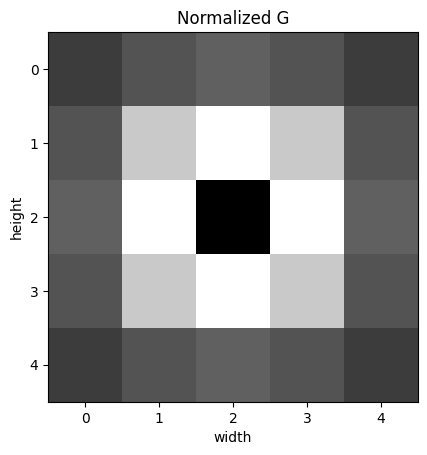

In [20]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
def show_img(img,title,xlabel,ylabel):
    plt.figure()
    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
def filter(img,kernel,kernel_size):
    r = kernel_size //2 # 圖片半徑 r=2 
    # print(img)
    height,width = img.shape[0:2]
    # 填充 
    padding_img = np.pad(img,(r,r)) 
    # print(padding_img)
    new_img = np.zeros_like(img)
    for y in range(r,height+r):
        for x in range(r,width+r):
            region = padding_img[(y-r):(y+r+1),(x-r):(x+r+1)]# y ,x = 2-2,2+2+1
            conv = np.sum(region*kernel)
            new_img[y-r,x-r] = conv
    return new_img
# 輸入圖片
# img = cv2.imread("images.jpg")
# gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

gray_img = np.array(
[
    [20,20,20,20,20],
    [20,50,50,50,20],
    [20,50,255,50,20],
    [20,50,50,50,20],
    [20,20,20,20,20]
]

)
sobel_GX = np.array([[-1,0,1],
                     [-2,0,2],
                     [-1,0,1]])
sobel_GY = np.array([[-1,-2,-1],
                     [0,0,0],
                     [1,2,1]])
# print(sobel_GX)
# print(sobel_GY)
show_img(gray_img,"Gray","width","height")
Gx_img = filter(gray_img,sobel_GX,3)
Gy_img = filter(gray_img,sobel_GY,3)
# show_img(Gx_img,"Gx","width","height")
# show_img(Gy_img,"Gy","width","height")
G_img = (Gx_img**2 + Gy_img**2)**0.5
# show_img(G_img,"G","width","height")

# 梯度方向
theta = np.arctan2(Gy_img,Gx_img)
G_img_normalized = (G_img - np.min(G_img)) / (np.max(G_img) - np.min(G_img)) * 255
show_img(G_img_normalized, "Normalized G", "width", "height")
# show_img(theta,"theta","width","height")


### 2. 非最大值抑制
梯度方向量化到四个主要方向之一（通常是0°, 45°, 90°, 和135°），這樣做是為了簡化後續的邊緣追蹤過程。

[[ 0.78539816  1.39612413  1.57079633  1.74546853  2.35619449]
 [ 0.1746722   0.78539816  1.57079633  2.35619449  2.96692045]
 [ 0.          0.          0.          3.14159265  3.14159265]
 [-0.1746722  -0.78539816 -1.57079633 -2.35619449 -2.96692045]
 [-0.78539816 -1.39612413 -1.57079633 -1.74546853 -2.35619449]]


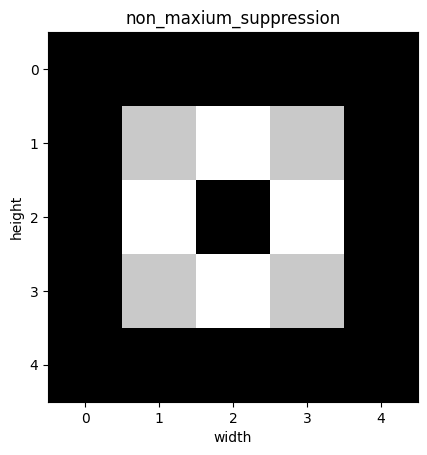

In [22]:
import numpy as np

def non_maximum_suppression(G, theta):
    M, N = G.shape
    Z = np.zeros((M,N), dtype=np.float32)
    angle = theta * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
                #角度0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = G[i, j+1]
                    r = G[i, j-1]
                #角度45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = G[i+1, j-1]
                    r = G[i-1, j+1]
                #角度90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = G[i+1, j]
                    r = G[i-1, j]
                #角度135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = G[i-1, j-1]
                    r = G[i+1, j+1]

                if (G[i,j] >= q) and (G[i,j] >= r):
                    Z[i,j] = G[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z
print(theta)
non_maxium_suppression_img = non_maximum_suppression(G_img, theta)
show_img(non_maxium_suppression_img,"non_maxium_suppression","width","height")
